In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
import pymongo
import json
import re
import string
import nltk
import emoji
import matplotlib.pyplot as plt
from datetime import datetime

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

import text2emotion as te

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hduser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Insert Data into Mongo

In [2]:
#Set up variables to access MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
# Database Name
database = client["collegedb"]
# Collection Name
collection = database["senators"]
collectionSentiment = database["senatorsSent"]
collectionSentiment2 = database["senatorsSent2"]
tweetDailyAggregate = database["senatorsAgg"]

# Access Mongo and import data

In [3]:
# Show connection
collection

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'collegedb'), 'senators')

In [4]:
tweets = pd.DataFrame.from_records(list(collection.find()))

In [5]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets['date']=pd.to_datetime(tweets['created_at']).dt.date.astype("datetime64[ns]")
tweets['dayNum']=tweets['created_at'].dt.day
tweets['day']=tweets['created_at'].dt.dayofweek
tweets['hour']=tweets['created_at'].dt.hour

print(tweets.isnull().sum())
print(tweets.info())
print(tweets.shape)
#tweets['date'].groupby(tweets["date"].dt.date).count().plot(kind="bar")

/tmp/ipykernel_10270/4046566047.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets['created_at'] = pd.to_datetime(tweets['created_at'])


_id            0
created_at     0
text           0
url            0
replies        0
retweets       0
favorites      0
user           0
bioguide_id    0
party          0
state          0
date           0
dayNum         0
day            0
hour           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288615 entries, 0 to 288614
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   _id          288615 non-null  object        
 1   created_at   288615 non-null  datetime64[ns]
 2   text         288615 non-null  object        
 3   url          288615 non-null  object        
 4   replies      288615 non-null  int64         
 5   retweets     288615 non-null  int64         
 6   favorites    288615 non-null  int64         
 7   user         288615 non-null  object        
 8   bioguide_id  288615 non-null  object        
 9   party        288615 non-null  object        
 10  state        288

In [8]:
df=tweets[(tweets['date'] >= '2016-7-20')&((tweets['date'] <= '2017-10-20'))]

# Text Cleaning and preperation for sentiment analysis

In [6]:
def remove_duplicates(sentence):
    words = sentence.split(" ")
    result = []
    for word in words:
        if word not in result:
            result.append(word)
    return " ".join(result)

def clean_text(text):
    # Convert text to lowercase
    text = str(text).lower()
    # Remove urls
    text = re.sub(r'http\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Remove emojis
    text = (emoji.replace_emoji(text, ''))
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra chars
    text = re.sub(r"[^\w\s]+", "", text)
    # Remove Duplicates
    text = remove_duplicates(text)
    # Tokenize text into words
    words = nltk.word_tokenize(text)
    # Lemmatize words
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]
    # Remove stop words
    words = [word for word in words if word not in stpwrd]
    # Join words back into text
    text = ' '.join(words)
    return text

def count_words(s):
    return len(s.split())

In [7]:
tweets.shape

(288615, 15)

In [9]:
df.shape

(147675, 15)

In [10]:
#Add commonly seen words that are not info related.
new_stopwords = ["amp", "rt", "w", "wa"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

df['clean_text'] = df['text'].apply(clean_text)
df['countWords'] = df['clean_text'].apply(count_words)
df = df[df['countWords']>5]
print(df.shape)

(132042, 17)


/tmp/ipykernel_10270/2396548474.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(clean_text)
/tmp/ipykernel_10270/2396548474.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['countWords'] = df['clean_text'].apply(count_words)


In [ ]:
df.head(5)

# Perform Sentiment Analysis

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

df['polarity'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x))
df['emotion'] = df['clean_text'].apply(lambda x: te.get_emotion(x))


# Save to MongoDB

In [ ]:
df = pd.DataFrame.from_records(list(collectionSentiment.find()))

# Extract Sentiment and Emotive Values

In [13]:
#import ast
#df['polarity']= df['polarity'].apply(ast.literal_eval)
df['compound'] = df['polarity'].apply(lambda x: x['compound'])
df['pos'] = df['polarity'].apply(lambda x: x['pos'])
df['neu'] = df['polarity'].apply(lambda x: x['neu'])
df['neg'] = df['polarity'].apply(lambda x: x['neg'])
#df['emotion']= df['emotion'].apply(ast.literal_eval)
df['happy'] = df['emotion'].apply(lambda x: x['Happy'])
df['angry'] = df['emotion'].apply(lambda x: x['Angry'])
df['surprise'] = df['emotion'].apply(lambda x: x['Surprise'])
df['sad'] = df['emotion'].apply(lambda x: x['Sad'])
df['fear'] = df['emotion'].apply(lambda x: x['Fear'])


In [14]:
bins=[-2, -0.5, 0.5, 1]
labels=[1, 2, 3]
df['sentiment'] = pd.cut(df['compound'], bins, labels=labels)

In [15]:
df.isna().sum()

_id            0
created_at     0
text           0
url            0
replies        0
retweets       0
favorites      0
user           0
bioguide_id    0
party          0
state          0
date           0
dayNum         0
day            0
hour           0
clean_text     0
countWords     0
polarity       0
emotion        0
compound       0
pos            0
neu            0
neg            0
happy          0
angry          0
surprise       0
sad            0
fear           0
sentiment      0
dtype: int64

In [16]:
df = df.sort_values(by='date', ascending=True)

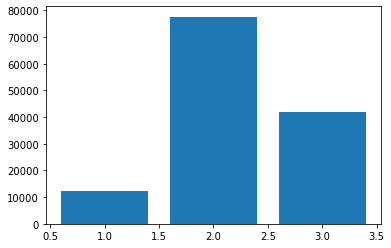

In [99]:
counts = df['sentiment'].value_counts()
plt.bar(counts.index, counts.values)
plt.show()

<AxesSubplot:xlabel='date', ylabel='count'>

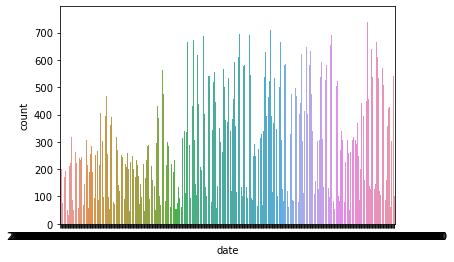

In [18]:
sns.countplot(x='date', data=df)

# Define Aggregation Fucnction and apply to collection of tweets

In [19]:
def dailyAgg(dfAdj, columns_to_aggregate):    
    # Resample the dataframe and calculate summary statistics
    dfAdj.set_index('date', inplace=True)
    aggregation_functions = {col: ['min', 'max', 'mean', 'std', 'count'] for col in columns_to_aggregate}
    df_daily = dfAdj.resample('D').agg(aggregation_functions)
    df_daily.columns = ['_'.join(col) for col in df_daily.columns]
    #df_daily = df_daily.reset_index()
    return df_daily

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132042 entries, 2016-07-20 to 2017-10-20
Data columns (total 28 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   _id          132042 non-null  object        
 1   created_at   132042 non-null  datetime64[ns]
 2   text         132042 non-null  object        
 3   url          132042 non-null  object        
 4   replies      132042 non-null  int64         
 5   retweets     132042 non-null  int64         
 6   favorites    132042 non-null  int64         
 7   user         132042 non-null  object        
 8   bioguide_id  132042 non-null  object        
 9   party        132042 non-null  object        
 10  state        132042 non-null  object        
 11  dayNum       132042 non-null  int32         
 12  day          132042 non-null  int32         
 13  hour         132042 non-null  int32         
 14  clean_text   132042 non-null  object        
 15  countWords   13204

In [120]:
df = df.reset_index()
df['date']=pd.to_datetime(df['date']).dt.date.astype("datetime64[ns]")
aggCols = ['compound', 'pos', 'neu', 'neg', 'happy', 'sad', 'fear', 'surprise', 'day', 'hour']
df_daily = dailyAgg(df, aggCols )

# Save Aggregated Tweets to MongoDB

In [176]:
df_daily = pd.DataFrame.from_records(list(tweetDailyAggregate.find()))

In [177]:
df_daily.shape

(458, 52)

# Create Shifted Variables

In [178]:
df_daily.head()

,_id,date,compound_min,compound_max,compound_mean,compound_std,compound_count,pos_min,pos_max,pos_mean,pos_std,pos_count,neu_min,neu_max,neu_mean,neu_std,neu_count,neg_min,neg_max,neg_mean,neg_std,neg_count,happy_min,happy_max,happy_mean,happy_std,happy_count,sad_min,sad_max,sad_mean,sad_std,sad_count,fear_min,fear_max,fear_mean,fear_std,fear_count,surprise_min,surprise_max,surprise_mean,surprise_std,surprise_count,day_min,day_max,day_mean,day_std,day_count,hour_min,hour_max,hour_mean,hour_std,hour_count
0,646bd102e0447bc15219fb94,2016-07-20,-0.9153,0.9493,0.265792,0.479928,235,0.0,0.841,0.266872,0.217031,235,0.159,1.0,0.642834,0.225784,235,0.0,0.716,0.090260,0.152661,235,0.0,1.0,0.189362,0.294344,235,0.0,1.0,0.161319,0.287073,235,0.0,1.0,0.332468,0.355388,235,0.0,1.0,0.148043,0.263934,235,2,2,2.0,0.0,235,0,23,17.136170,4.609375,235
1,646bd102e0447bc15219fb95,2016-07-21,-0.8625,0.9670,0.303180,0.432893,214,0.0,0.876,0.258500,0.218380,214,0.124,1.0,0.673369,0.225996,214,0.0,0.658,0.068112,0.122584,214,0.0,1.0,0.214860,0.333592,214,0.0,1.0,0.133364,0.251416,214,0.0,1.0,0.387477,0.383102,214,0.0,1.0,0.133318,0.267402,214,3,3,3.0,0.0,214,0,23,16.663551,4.838119,214
2,646bd102e0447bc15219fb96,2016-07-22,-0.9136,0.9565,0.194575,0.482123,200,0.0,0.946,0.224355,0.210097,200,0.054,1.0,0.677190,0.213142,200,0.0,0.692,0.098465,0.158290,200,0.0,1.0,0.157950,0.271516,200,0.0,1.0,0.150950,0.281756,200,0.0,1.0,0.388250,0.378834,200,0.0,1.0,0.120300,0.241011,200,4,4,4.0,0.0,200,0,23,16.010000,6.087296,200
3,646bd102e0447bc15219fb97,2016-07-23,-0.9360,0.9337,0.381474,0.499433,77,0.0,0.800,0.326974,0.229412,77,0.200,1.0,0.593429,0.201840,77,0.0,0.641,0.079623,0.144015,77,0.0,1.0,0.265065,0.347156,77,0.0,1.0,0.184935,0.275584,77,0.0,1.0,0.269091,0.327535,77,0.0,1.0,0.084026,0.174878,77,5,5,5.0,0.0,77,0,23,12.623377,8.044349,77
4,646bd102e0447bc15219fb98,2016-07-24,-0.8126,0.9360,0.231557,0.530135,37,0.0,0.741,0.257703,0.240075,37,0.259,1.0,0.639297,0.211431,37,0.0,0.646,0.103000,0.175101,37,0.0,1.0,0.113514,0.226939,37,0.0,1.0,0.184865,0.295622,37,0.0,1.0,0.329459,0.324730,37,0.0,1.0,0.164865,0.264991,37,6,6,6.0,0.0,37,1,23,16.621622,5.898923,37


In [179]:
df_daily = df_daily.reset_index()
df_daily['date']=pd.to_datetime(df_daily['date']).dt.date.astype("datetime64[ns]")
df_daily['date_col'] = df_daily['date'].dt.date.astype("datetime64[ns]")
df_daily = df_daily.set_index('date')
df_daily.head(500)

,index,_id,compound_min,compound_max,compound_mean,compound_std,compound_count,pos_min,pos_max,pos_mean,pos_std,pos_count,neu_min,neu_max,neu_mean,neu_std,neu_count,neg_min,neg_max,neg_mean,neg_std,neg_count,happy_min,happy_max,happy_mean,happy_std,happy_count,sad_min,sad_max,sad_mean,sad_std,sad_count,fear_min,fear_max,fear_mean,fear_std,fear_count,surprise_min,surprise_max,surprise_mean,surprise_std,surprise_count,day_min,day_max,day_mean,day_std,day_count,hour_min,hour_max,hour_mean,hour_std,hour_count,date_col
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-20,0,646bd102e0447bc15219fb94,-0.9153,0.9493,0.265792,0.479928,235,0.0,0.841,0.266872,0.217031,235,0.159,1.0,0.642834,0.225784,235,0.0,0.716,0.090260,0.152661,235,0.0,1.00,0.189362,0.294344,235,0.0,1.00,0.161319,0.287073,235,0.0,1.0,0.332468,0.355388,235,0.0,1.0,0.148043,0.263934,235,2,2,2.0,0.0,235,0,23,17.136170,4.609375,235,2016-07-20
2016-07-21,1,646bd102e0447bc15219fb95,-0.8625,0.9670,0.303180,0.432893,214,0.0,0.876,0.258500,0.218380,214,0.124,1.0,0.673369,0.225996,214,0.0,0.658,0.068112,0.122584,214,0.0,1.00,0.214860,0.333592,214,0.0,1.00,0.133364,0.251416,214,0.0,1.0,0.387477,0.383102,214,0.0,1.0,0.133318,0.267402,214,3,3,3.0,0.0,214,0,23,16.663551,4.838119,214,2016-07-21
2016-07-22,2,646bd102e0447bc15219fb96,-0.9136,0.9565,0.194575,0.482123,200,0.0,0.946,0.224355,0.210097,200,0.054,1.0,0.677190,0.213142,200,0.0,0.692,0.098465,0.158290,200,0.0,1.00,0.157950,0.271516,200,0.0,1.00,0.150950,0.281756,200,0.0,1.0,0.388250,0.378834,200,0.0,1.0,0.120300,0.241011,200,4,4,4.0,0.0,200,0,23,16.010000,6.087296,200,2016-07-22
2016-07-23,3,646bd102e0447bc15219fb97,-0.9360,0.9337,0.381474,0.499433,77,0.0,0.800,0.326974,0.229412,77,0.200,1.0,0.593429,0.201840,77,0.0,0.641,0.079623,0.144015,77,0.0,1.00,0.265065,0.347156,77,0.0,1.00,0.184935,0.275584,77,0.0,1.0,0.269091,0.327535,77,0.0,1.0,0.084026,0.174878,77,5,5,5.0,0.0,77,0,23,12.623377,8.044349,77,2016-07-23
2016-07-24,4,646bd102e0447bc15219fb98,-0.8126,0.9360,0.231557,0.530135,37,0.0,0.741,0.257703,0.240075,37,0.259,1.0,0.639297,0.211431,37,0.0,0.646,0.103000,0.175101,37,0.0,1.00,0.113514,0.226939,37,0.0,1.00,0.184865,0.295622,37,0.0,1.0,0.329459,0.324730,37,0.0,1.0,0.164865,0.264991,37,6,6,6.0,0.0,37,1,23,16.621622,5.898923,37,2016-07-24
2016-07-25,5,646bd102e0447bc15219fb99,-0.8689,0.9413,0.231939,0.431621,147,0.0,0.766,0.233544,0.203792,147,0.222,1.0,0.687122,0.217397,147,0.0,0.474,0.079320,0.131163,147,0.0,1.00,0.126122,0.244508,147,0.0,1.00,0.159728,0.286083,147,0.0,1.0,0.385918,0.402526,147,0.0,1.0,0.174082,0.297217,147,0,0,0.0,0.0,147,0,23,17.170068,3.722155,147,2016-07-25
2016-07-26,6,646bd102e0447bc15219fb9a,-0.9638,0.9022,0.292591,0.424593,173,0.0,0.724,0.248786,0.213341,173,0.198,1.0,0.686561,0.231974,173,0.0,0.731,0.064665,0.136058,173,0.0,1.00,0.186647,0.316473,173,0.0,1.00,0.134682,0.275074,173,0.0,1.0,0.409942,0.408592,173,0.0,1.0,0.115838,0.268268,173,1,1,1.0,0.0,173,0,23,16.774566,4.618094,173,2016-07-26
2016-07-27,7,646bd102e0447bc15219fb9b,-0.9042,0.9274,0.277319,0.451648,194,0.0,0.779,0.253412,0.231526,194,0.221,1.0,0.680737,0.235453,194,0.0,0.664,0.065881,0.130010,194,0.0,1.00,0.176856,0.304067,194,0.0,1.00,0.184381,0.287543,194,0.0,1.0,0.387938,0.389231,194,0.0,1.0,0.136701,0.264261,194,2,2,2.0,0.0,194,0,23,16.391753,5.463125,194,2016-07-27
2016-07-28,8,646bd102e0447bc15219fb9c,-0.8977,0.8910,0.327751,0.433400,213,0.0,0.711,0.280230,0.213207,213,0.155,1.0,0.656676,0.217030,213,0.0,0.727,0.063085,0.130234,213,0.0,1.00,0.213192,0.317735,213,0.0,1.00,0.185446,0.307219,213,0.0,1.0,0.297934,0.344006,213,0.0,1.0,0.169859,0.300690,213,3,3,3.0,0.0,213,0,23,14.342723,7.085722,213,2016-07-28


In [180]:
df_daily['compound_n1d'] = df_daily['compound_mean'].shift(freq="1D")
df_daily['compound_n7d'] = df_daily['compound_mean'].shift(freq="7D") 
df_daily['compound_n1m'] = df_daily['compound_mean'].shift(freq="30D") 
df_daily['compound_n3m'] = df_daily['compound_mean'].shift(freq="90D") 

In [181]:
keepCols = ['date_col','compound_mean', 'happy_mean', 'sad_mean', 'fear_mean', 'surprise_mean', 'compound_n1d', 'compound_n7d', 'compound_n1m', 'compound_n3m']
cols = ['compound_mean', 'happy_mean', 'sad_mean', 'fear_mean', 'surprise_mean']

In [182]:
df_daily= df_daily[keepCols]

In [183]:
for col in cols:
    df_daily[col+'_7d_avg'] = df_daily[col].rolling(window=7).mean()
    df_daily[col+'_30d_avg'] = df_daily[col].rolling(window=30).mean()
    df_daily[col+'_1d_diff'] = df_daily[col].diff(1)
    df_daily[col+'_7d_diff'] = df_daily[col].diff(7)

In [197]:
modelCols = [
    'compound_mean'
    ,'happy_mean'
    ,'sad_mean'
    ,'fear_mean'
    ,'surprise_mean'
    ,'compound_mean_7d_avg'
    ,'compound_mean_30d_avg'
    ,'compound_mean_1d_diff'
    ,'compound_mean_7d_diff'
    ,'happy_mean_7d_avg'
    ,'happy_mean_30d_avg'
    ,'happy_mean_1d_diff'
    ,'happy_mean_7d_diff'
    ,'sad_mean_7d_avg'
    ,'sad_mean_30d_avg'
    ,'sad_mean_1d_diff'
    ,'sad_mean_7d_diff'
    ,'fear_mean_7d_avg'
    ,'fear_mean_30d_avg'
    ,'fear_mean_1d_diff'
    ,'fear_mean_7d_diff'
    ,'surprise_mean_7d_avg'
    ,'surprise_mean_30d_avg'
    ,'surprise_mean_1d_diff'
    ,'surprise_mean_7d_diff'
]
targetCols= [ 'compound_n1d', 'compound_n7d' ,'compound_n1m', 'compound_n3m']

In [198]:
df_model = df_daily[df_daily['date_col'] >= '2016-10-19']
df_model.shape

(367, 30)

In [216]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

def run_regression_models(df, target_cols, var_cols):
    # Split the data into input features (X) and target variables (y)
    X = df[var_cols]
    y = df[target_cols]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    # Scale the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train linear regression models
    linear_models = {}
    for target_col in target_cols:
        model = LinearRegression()
        model.fit(X_train_scaled, y_train[target_col])
        linear_models[target_col] = model

    # Train neural network models
    nn_models = {}
    for target_col in target_cols:
        model = MLPRegressor(hidden_layer_sizes=(100, 50, 50, 50), random_state=666)
        model.fit(X_train_scaled, y_train[target_col])
        nn_models[target_col] = model

    # Scale the test set
    X_test_scaled = scaler.transform(X_test)

    # Make predictions on the test set and evaluate performance
    linear_predictions = {}
    nn_predictions = {}
    for target_col in target_cols:
        linear_predictions[target_col] = linear_models[target_col].predict(X_test_scaled.reshape(-1, X_test_scaled.shape[1]))
        nn_predictions[target_col] = nn_models[target_col].predict(X_test_scaled)

    # Calculate the root mean squared error (RMSE) for each target variable
    linear_rmse = {}
    nn_rmse = {}
    for target_col in target_cols:
        linear_rmse[target_col] = np.sqrt(mean_squared_error(y_test[target_col], linear_predictions[target_col]))
        nn_rmse[target_col] = np.sqrt(mean_squared_error(y_test[target_col], nn_predictions[target_col]))

    # Print the RMSE values
    print('Linear Regression RMSE:')
    print(linear_rmse)
    print('\nNeural Network RMSE:')
    print(nn_rmse)
    

In [217]:
run_regression_models(df_model, targetCols, modelCols)

Linear Regression RMSE:
{'compound_n1d': 5.796058227984799e-16, 'compound_n7d': 5.506776837096948e-16, 'compound_n1m': 0.0872813488438011, 'compound_n3m': 0.06974589404121057}

Neural Network RMSE:
{'compound_n1d': 0.07261452879086192, 'compound_n7d': 0.06940167297736724, 'compound_n1m': 0.11228837497768843, 'compound_n3m': 0.10025847155603837}


In [ ]:
# Plot the predictions
import matplotlib.pyplot as plt
plt.plot(df['date'][n_steps:train_size], df['sentiment'][n_steps:train_size], label='Training Data')
plt.plot(df['date'][train_size+n_steps:], df['sentiment'][train_size+n_steps:], label='Testing Data')
plt.plot(df['date'][n_steps:train_size], y_train_pred, label='Training Predictions')
plt.plot(df['date'][train_size+n_steps:], y_test_pred, label='Testing Predictions')
plt.legend()
plt.show()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MongoDBInput") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/college.news") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/college.news") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.13:10.1.1") \
    .getOrCreate()

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/college.news") \
    .load()